In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import os,sys
import glob
import scipy
from scipy import interpolate

from astropy.cosmology import Planck15 as P15
from astropy import units as u
from astropy import constants as const

import run_LF as LF

plt.style.use(['default','seaborn-colorblind','seaborn-ticks'])
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

# Test adding uncertainty to LF model

- If model UV LF has 0.2dex uncertainty at every Muv value, what is uncertainty in Lya LF model?
- How does Lya LF model uncertainty change neutral fraction inference?

In [64]:
model_dir = os.environ['LYA_DATA_DIR']+'data/models/'
UVLF_dir  = model_dir+'MTT15_UVLF/LF_pred/'

LF_tab = LF.load_uvf_pandas(UVLF_dir+'LF_pred_z6.8.txt')

## Make LF with 0.2 dex uncertainty

(1e-07, 0.1)

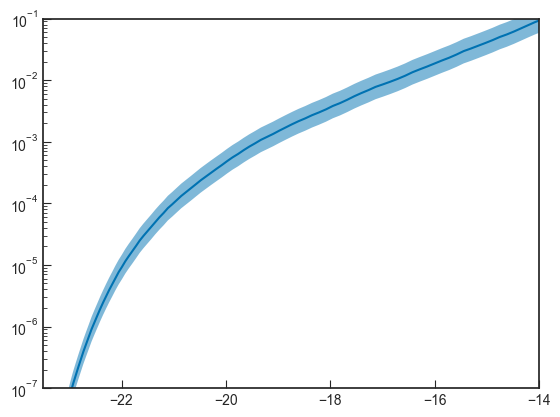

In [85]:
log_ndens_sigma = 0.2
ndens_l = 10**(np.log10(LF_tab['ndens']) - log_ndens_sigma)
ndens_u = 10**(np.log10(LF_tab['ndens']) + log_ndens_sigma)

plt.semilogy(LF_tab['Muv'], LF_tab['ndens'])
plt.fill_between(LF_tab['Muv'], ndens_l, ndens_u, alpha=0.5)

plt.xlim(-23.5,-14)
plt.ylim(1e-7, 1e-1)

(-7.0, -1.0)

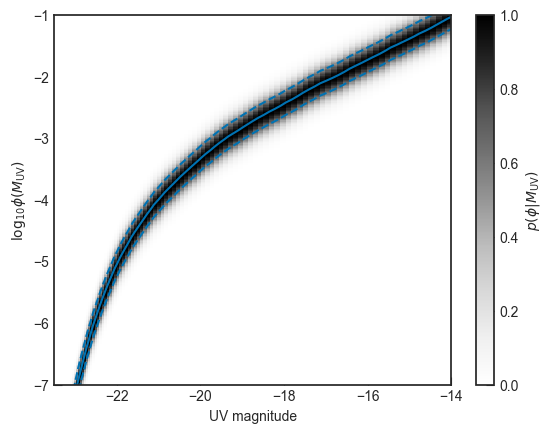

In [89]:
def make_p_ndens(ndens_grid, ndens, sigma=0.2):
    p = np.exp(-0.5*((np.log10(ndens_grid) - np.log10(ndens))**2.)/sigma**2.)/ndens_grid/np.log(10.)/np.sqrt(2*np.pi)/sigma
    return p

ndens_grid = np.logspace(-10,1, 500)

p_ndens = make_p_ndens(ndens_grid, LF_tab['ndens'][:,None], sigma=0.2)
plt.pcolor(LF_tab['Muv'], np.log10(ndens_grid), (p_ndens/np.max(p_ndens, axis=0)).T)

plt.colorbar(label=r'$p(\phi | M_\mathrm{UV})$')

ln = plt.plot(LF_tab['Muv'], np.log10(LF_tab['ndens']), label='Mean + upper + lower uncertainties')
plt.plot(LFtab['Muv'], np.log10(ndens_l), c=ln[0].get_color(), ls='dashed')
plt.plot(LFtab['Muv'], np.log10(ndens_u), c=ln[0].get_color(), ls='dashed')


plt.xlabel('UV magnitude')
plt.ylabel(r'$\log_{10} \phi(M_\mathrm{UV})$')

plt.xlim(-23.5,-14)
plt.ylim(-7, -1)

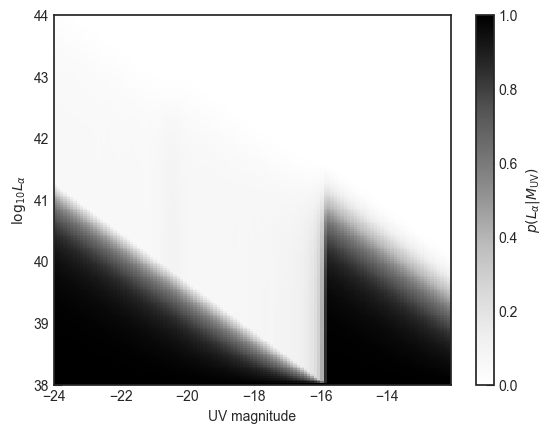

In [90]:
Muv_grid, pL_Lya = LF.make_pL_Lya(zval_test=6.8, xHI_test=0.01)

plt.pcolor(Muv_grid, LF.log10_lg, pL_Lya/np.max(pL_Lya, axis=0))

plt.xlabel('UV magnitude')
plt.ylabel(r'$\log_{10} L_\alpha$')

plt.colorbar(label=r'$p(L_\alpha | M_\mathrm{UV})$')

In [69]:
print(LF_tab['Muv'].shape, ndens_grid.shape, p_ndens.shape)

(181,) (500,) (181, 500)


(500, 120) (200, 120) (120,)
(200, 500, 120)
(200, 500)


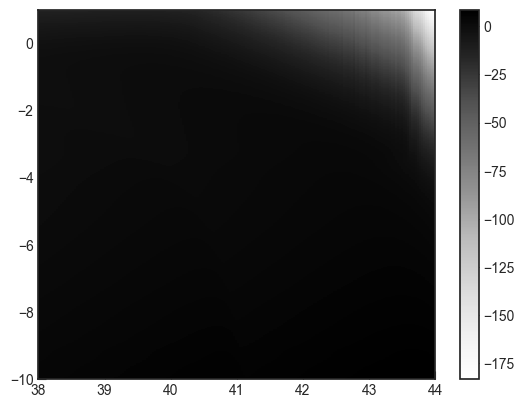

In [116]:
def make_lya_LF(p_ndens, new_pLya, F=1., plot=False, log=True):
    
#     #Calling UV, EW, Konno files to obtain z and xHI values
#     LFz_file = sorted(insensitive_glob(LFz_dir+ f'LF_pred_z{zval_test}.txt'))[0] 
    
#     # Make p(L_Lya | Muv)
#     Muv_grid, new_pLya = make_pL_Lya(zval_test, xHI_test)
    
#     #Load in z value file
#     LF_tab = load_uvf_pandas(LFz_file) 
    
    
    #Interpolating UV LF Muv and ndens values into a 2d array
    LF_interp = interpolate.interp2d(LF_tab['Muv'], ndens_grid, p_ndens.T) #old values
    new_ndens = LF_interp(Muv_grid, ndens_grid)

    print(new_ndens.shape, new_pLya.shape, Muv_grid.shape)
    #Product of UVLF ndens values * pLya in new luminosity grid
    product_LF = new_ndens * new_pLya[:,None]

    print(product_LF.shape)

    #Integral of this product = Lya LF (missing fudge factor corrections)
    lya_LF =np.trapz(product_LF, x = Muv_grid) 

    print(lya_LF.shape)

    #Log10 of Lya LF is lya_LF value * Jacobian - partial L / partial log10(L)
    log10_LF = lya_LF*np.log(10)*LF.lum_grid[:,None]
    
    plt.pcolor(LF.log10_lg, np.log10(ndens_grid), np.log10(log10_LF.T))
    plt.colorbar()
    
    return log10_LF

log10_LF = make_lya_LF(p_ndens=p_ndens, new_pLya=pL_Lya)

133
(200, 500)
(200,)


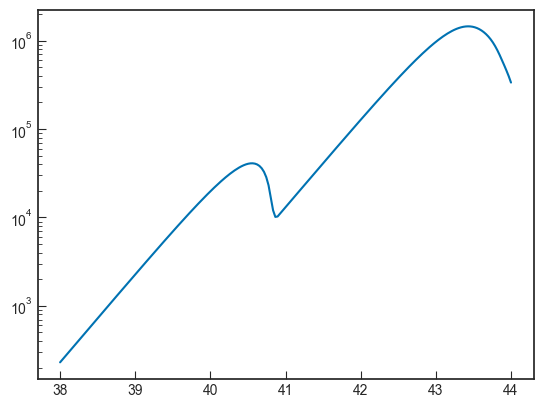

In [115]:
print(np.argmin(np.abs(LF.log10_lg - 42.)))

print(log10_LF.shape)
print(log10_LF[:,133].shape)
plt.semilogy(LF.log10_lg, log10_LF[:,133])